In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
from matplotlib.font_manager import FontProperties

# 设置为默认字体
plt.rcParams['font.family'] = 'Microsoft YaHei' # 或者 'Microsoft YaHei'

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('正样本比例', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% ')
print('负样本比例', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% ')

正样本比例 99.83 % 
负样本比例 0.17 % 


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

这段代码对数据集中的 Amount 和 Time 两列进行了归一化处理。由于大部分数据已经被缩放，因此只需要对剩余需要缩放的列进行缩放。

首先使用 StandardScaler() 函数创建一个标准缩放器对象 std_scaler，使用 RobustScaler() 函数创建一个稳健缩放器对象 rob_scaler。

然后，使用 rob_scaler.fit_transform() 函数将 Amount 列和 Time 列的值进行缩放，并且分别存储在新的 scaled_amount 和 scaled_time 列中。

接着，将原始数据集中的 Time 和 Amount 列删除。把 scaled_amount 和 scaled_time 列插入数据集的第一列和第二列，实现对数据集中 Amount 和 Time 列的缩放操作。

最后，输出数据集的前几行，可以看到新添加的 scaled_amount 和 scaled_time 列，以及删除的 Amount 和 Time 列。

In [4]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!
df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


这段代码用于将数据集划分为训练集和测试集，并检查标签的分布情况。

首先，使用 df.drop() 函数删除数据集中的 Class 列，并将其作为目标变量 y。然后，使用 StratifiedKFold() 函数将数据集划分为 5 折交叉验证的训练集和测试集。在每一折交叉验证中，函数会将数据集分成两部分：一部分用于训练模型，另一部分用于评估模型性能。

接着，使用 train_test_split() 函数再次将数据集划分为训练集和测试集，以便进行欠采样操作。但是，因为前面已经划分了交叉验证的训练集和测试集，所以此时只需要使用交叉验证产生的训练集和测试集即可。

然后，使用 np.unique() 函数获取训练集和测试集的标签值和数量，并打印标签分布情况。为了确保标签的分布情况和原始数据集相同，使用 len() 函数计算训练集和测试集的长度，并将其用作分母。最后，输出训练集和测试集的标签分布情况。

In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


这段代码用于将高度倾斜的数据集中的类别进行平衡，以得到正常分布的类别。

首先，使用 df.sample() 函数对整个数据集进行混洗，打乱数据集中样本的顺序。

接着，从数据集中选取所有标签为 1（即欺诈）的样本，并将其存储在 fraud_df 中。然后，从数据集中选取前 492 个标签为 0（即非欺诈）的样本，并将其存储在 non_fraud_df 中。因此，经过处理后，我们得到了两个大小相等、标签分布均匀的子数据集，其中一个只包含欺诈的样本，另一个则包含相同数量的非欺诈和欺诈样本。

最后，使用 pd.concat() 函数将 fraud_df 和 non_fraud_df 这两个子数据集合并成一个新的数据集 normal_distributed_df。然后再次使用 new_df.sample() 函数对整个数据集进行混洗，以打乱样本的顺序。最终输出新的数据集的前几行。

In [6]:
# 先打乱原始数据集
df = df.sample(frac=1)
# 取出欺诈类别的数据，共492行
fraud_df = df.loc[df['Class'] == 1]
# 取出非欺诈类别的数据，取前492行，使它和欺诈类别的数量相同
non_fraud_df = df.loc[df['Class'] == 0][:492]
# 将两个类别的数据合并为一个新的数据集
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# 打乱新数据集的行
new_df = normal_distributed_df.sample(frac=1, random_state=42)
# 返回新数据集的前几行以进行检查
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
242483,3.428771,0.785007,0.614457,-0.450841,-0.541430,-2.167016,-1.468521,1.212289,0.927759,-1.809588,...,-0.561431,-0.049187,-0.925053,0.394614,0.177131,-1.591535,-1.138876,-0.463991,-0.706983,0
221018,4.164186,0.677898,-3.367770,0.099249,-6.148487,3.401955,0.458307,-1.571630,-1.358708,0.672409,...,0.264699,0.861308,1.249301,1.850627,-0.117471,1.219815,0.000251,1.036011,0.004367,1
134409,-0.251799,-0.045795,-1.796022,1.987645,0.035994,1.064103,-0.461324,0.286288,-0.675611,1.475492,...,-0.375745,0.019023,-0.322049,0.009819,-0.436405,-0.225300,-0.488003,-0.592051,-0.046590,0
79536,-0.293440,-0.312797,-0.264869,3.386140,-3.454997,4.367629,3.336060,-2.053918,0.256890,-2.957235,...,0.482513,-1.394504,-0.166029,-1.452081,-0.251815,1.243461,0.452787,0.132218,0.424599,1
41943,-0.296793,-0.514574,-2.140511,4.104871,-8.996859,4.028391,-5.131359,-4.153568,-9.360095,1.922075,...,1.725578,1.854267,-0.165534,-0.339939,0.296314,1.364225,-0.518996,2.352333,1.130625,1


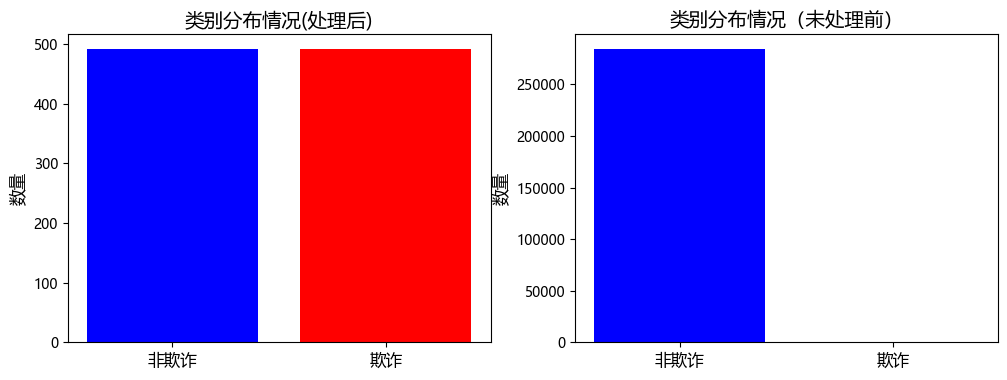

In [7]:
colors = ["blue","red"]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

# 在左图中绘制柱状图，展示各类别数量分布，使用指定颜色
ax1.bar([0, 1], new_df['Class'].value_counts(), color=colors)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['非欺诈', '欺诈'], fontsize=12)
ax1.set_ylabel('数量', fontsize=12)
ax1.set_title('类别分布情况(处理后)', fontsize=14)

# 在右图中绘制柱状图，展示原始数据中各类别数量分布，使用指定颜色
ax2.bar([0, 1], df['Class'].value_counts(), color=colors)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['非欺诈', '欺诈'], fontsize=12)
ax2.set_ylabel('数量', fontsize=12)
ax2.set_title('类别分布情况（未处理前）', fontsize=14)

plt.show()

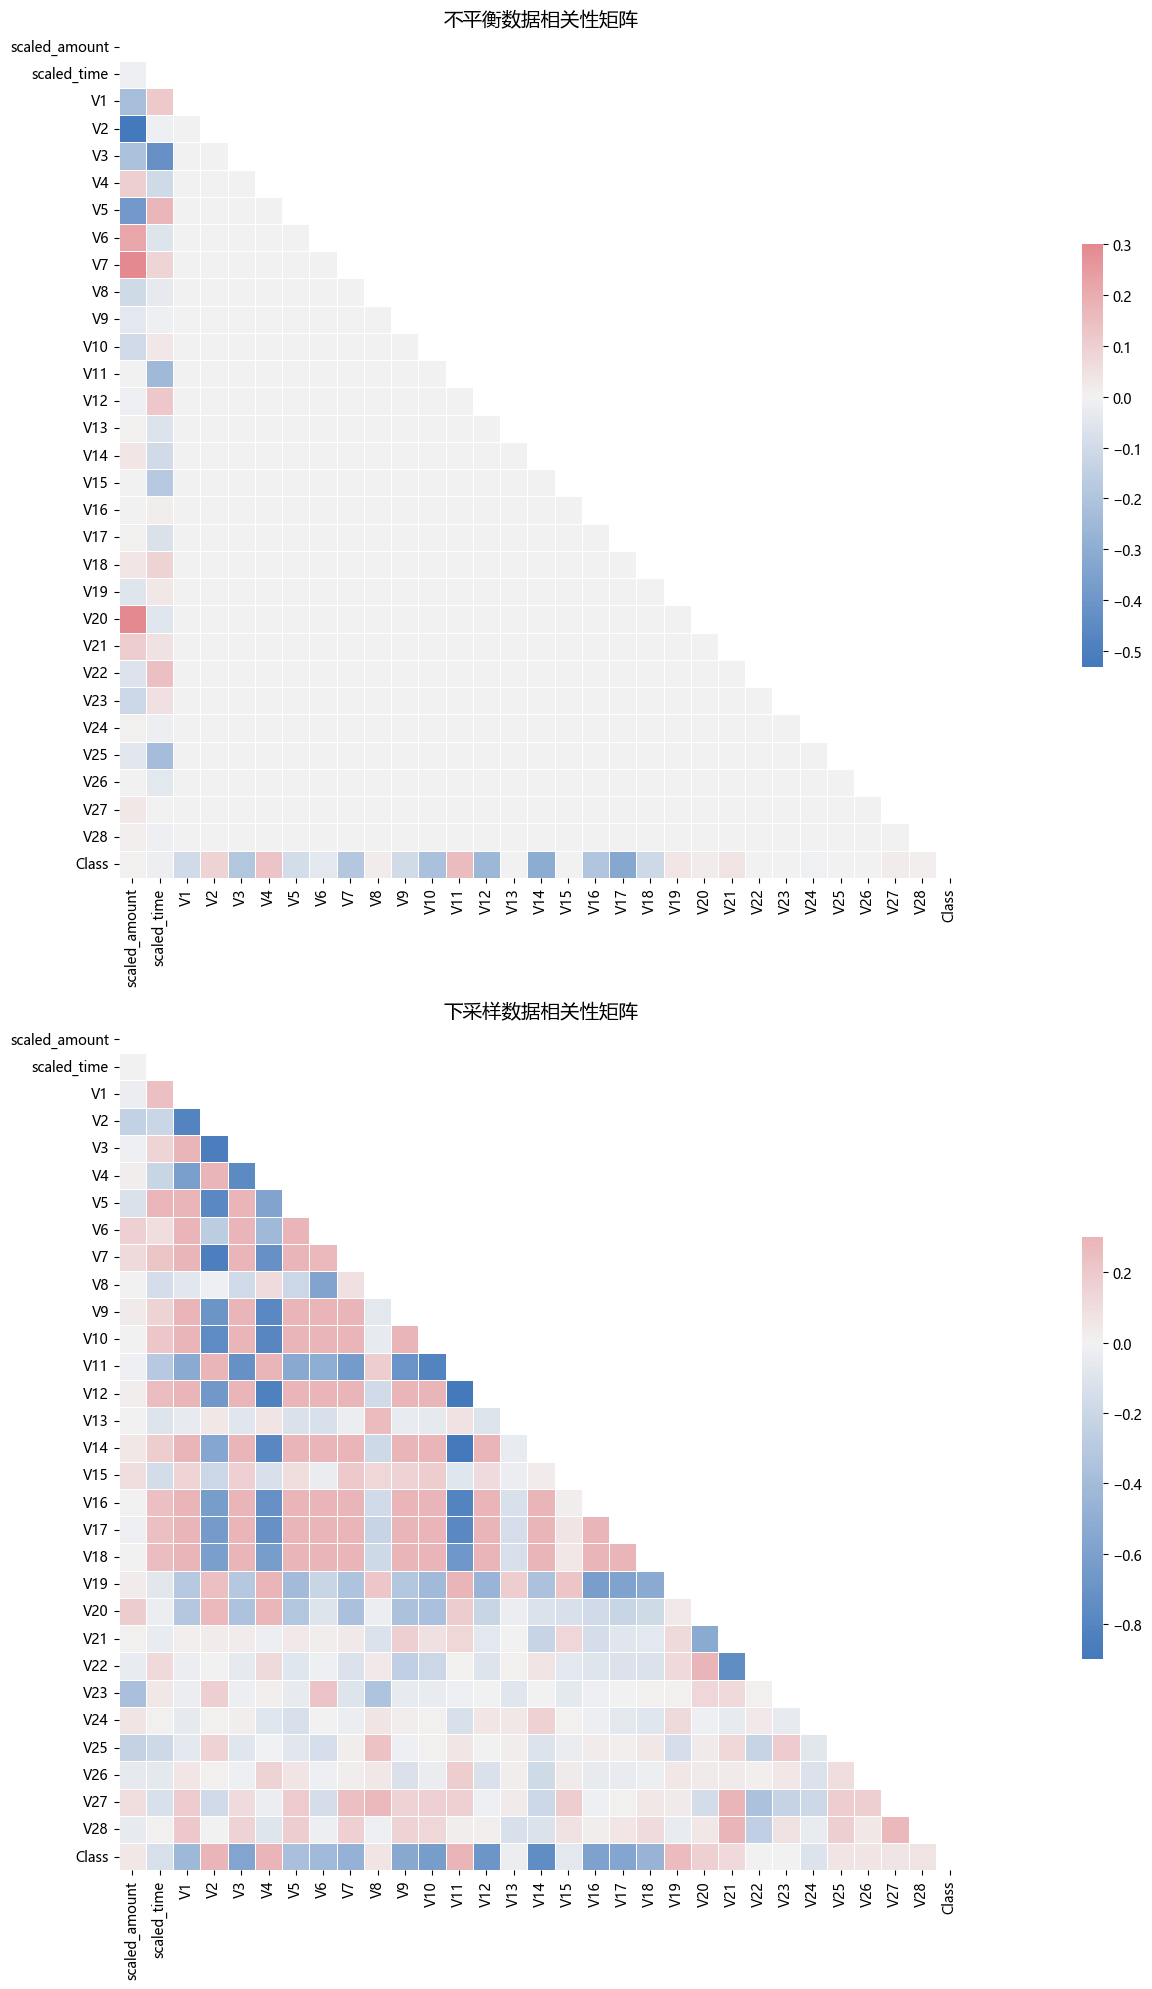

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Compute correlation matrices
corr = df.corr()
sub_corr = new_df.corr()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)

sns.heatmap(sub_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)

# Set the titles
ax1.set_title('不平衡数据相关性矩阵', fontsize=14)
ax2.set_title('下采样数据相关性矩阵', fontsize=14)

plt.tight_layout()
plt.show()


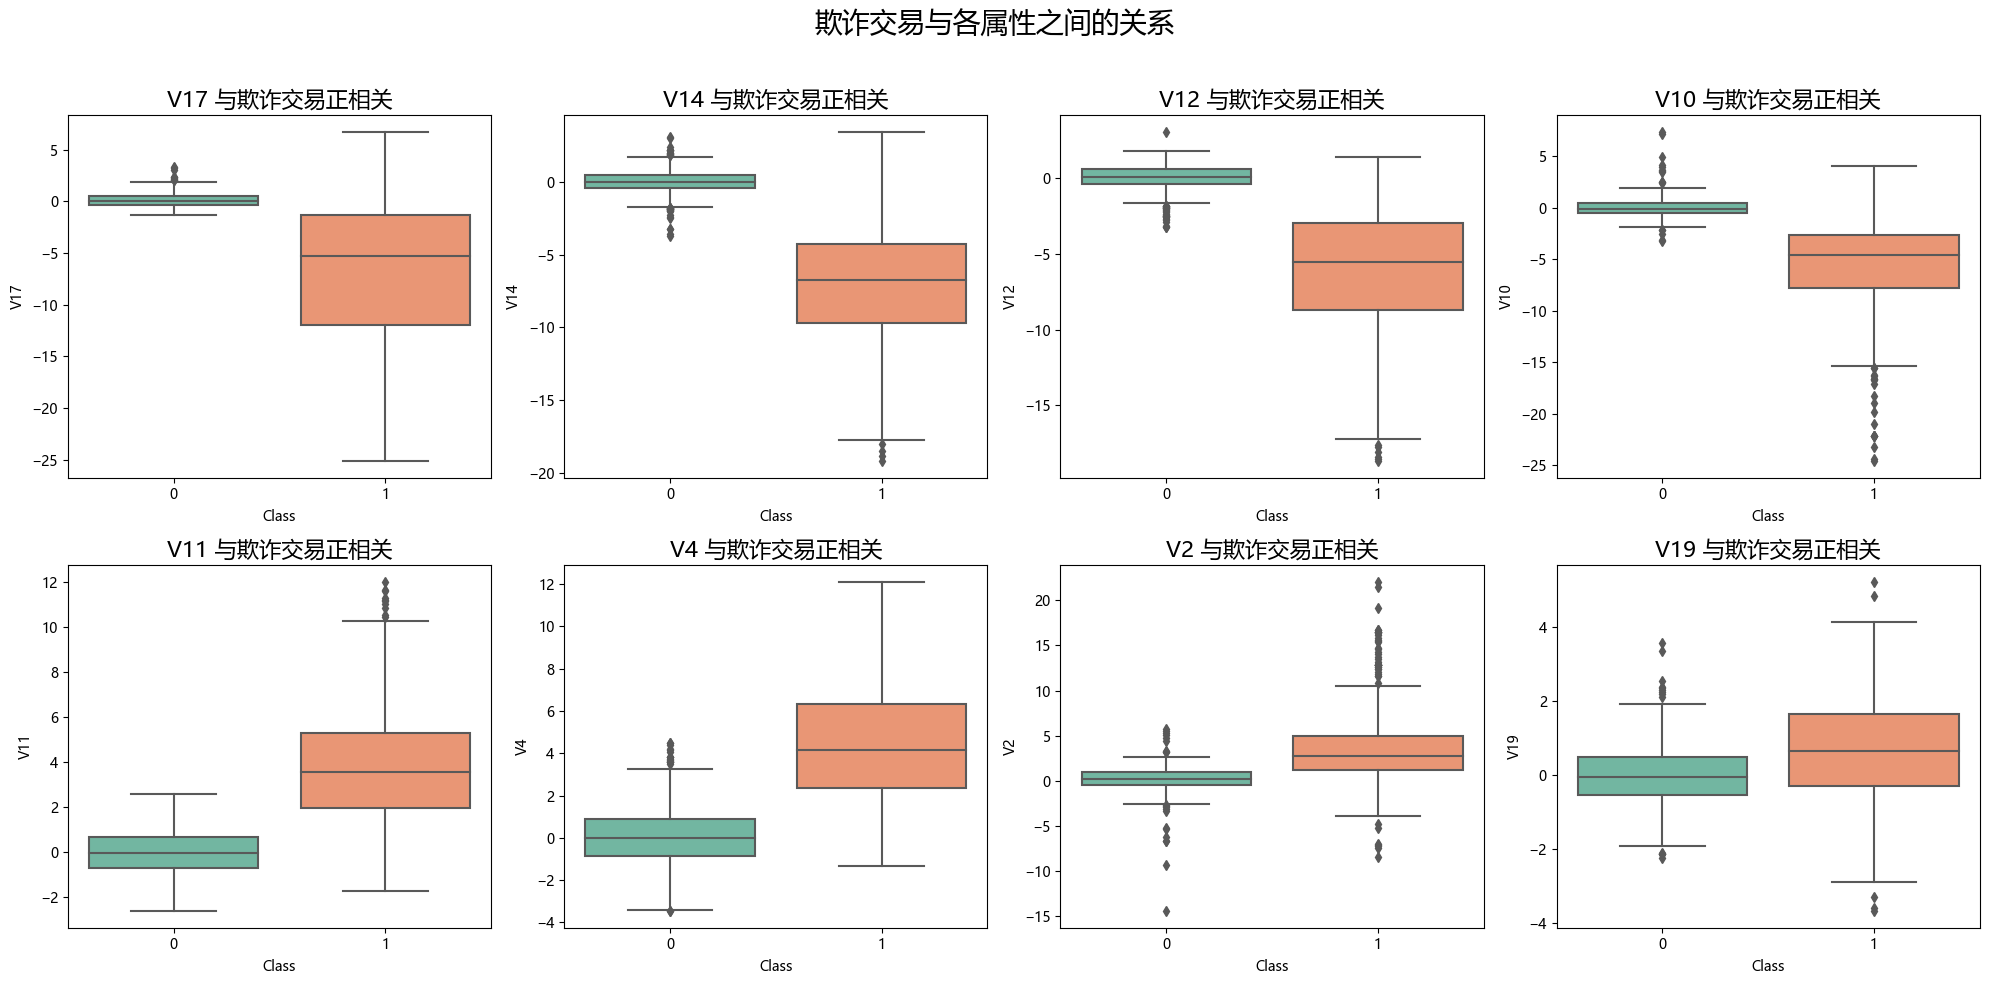

In [9]:
f, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,10))

# 使用较大的标题字体
title_fontsize = 16
label_fontsize = 12

# Define the new color palette
new_colors = 'Set2'

# Generate boxplots
sns.boxplot(x="Class", y="V17", data=new_df, palette=new_colors, ax=axes[0][0])
axes[0][0].set_title('V17 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V14", data=new_df, palette=new_colors, ax=axes[0][1])
axes[0][1].set_title('V14 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V12", data=new_df, palette=new_colors, ax=axes[0][2])
axes[0][2].set_title('V12 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V10", data=new_df, palette=new_colors, ax=axes[0][3])
axes[0][3].set_title('V10 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V11", data=new_df, palette=new_colors, ax=axes[1][0])
axes[1][0].set_title('V11 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V4", data=new_df, palette=new_colors, ax=axes[1][1])
axes[1][1].set_title('V4 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V2", data=new_df, palette=new_colors, ax=axes[1][2])
axes[1][2].set_title('V2 与欺诈交易正相关', fontsize=title_fontsize)

sns.boxplot(x="Class", y="V19", data=new_df, palette=new_colors, ax=axes[1][3])
axes[1][3].set_title('V19 与欺诈交易正相关', fontsize=title_fontsize)

# Set a global title
f.suptitle('欺诈交易与各属性之间的关系', fontsize=20)

# Use tight_layout to optimize the spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


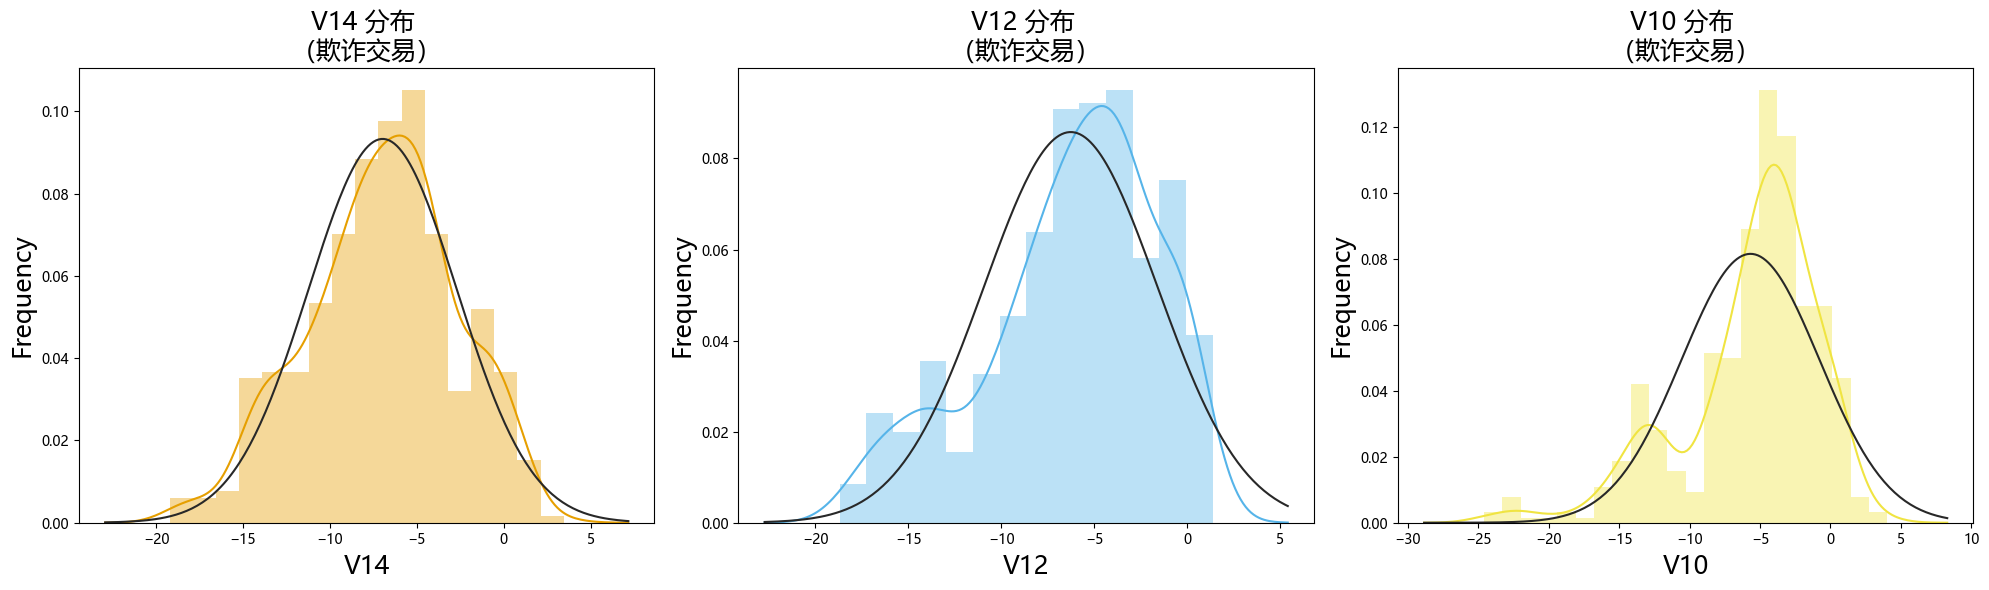

In [10]:
from scipy.stats import norm

# 绘制欺诈交易中 V14 特征的分布情况
v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
# 绘制欺诈交易中 V12 特征的分布情况
v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
# 绘制欺诈交易中 V10 特征的分布情况
v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

title_fontsize = 18

colors = ['#E69F00', '#56B4E9', '#F0E442']

sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color=colors[0])
ax1.set_title('V14 分布 \n（欺诈交易）', fontsize=title_fontsize)
ax1.set_xlabel('V14', fontsize=title_fontsize)
ax1.set_ylabel('Frequency', fontsize=title_fontsize)

sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color=colors[1])
ax2.set_title('V12 分布 \n（欺诈交易）', fontsize=title_fontsize)
ax2.set_xlabel('V12', fontsize=title_fontsize)
ax2.set_ylabel('Frequency', fontsize=title_fontsize)

sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color=colors[2])
ax3.set_title('V10 分布 \n（欺诈交易）', fontsize=title_fontsize)
ax3.set_xlabel('V10', fontsize=title_fontsize)
ax3.set_ylabel('Frequency', fontsize=title_fontsize)

plt.tight_layout()
plt.show()



In [11]:
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values  # 获取欺诈交易中的 V14 特征值
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)  # 计算 Q1 和 Q3
print('第一四分位数：{} | 第三四分位数：{}'.format(q25, q75))
v14_iqr = q75 - q25  # 计算 IQR

v14_cut_off = v14_iqr * 1.5  # 计算截止值
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('截止值：{}'.format(v14_cut_off))
print('V14 下限：{}'.format(v14_lower))
print('V14 上限：{}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]  # 筛选出离群值
print('欺诈交易中特征 V14 的离群值数量：{}'.format(len(outliers)))
print('V10 离群值: {}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)  # 去除离群值
print("\n")



v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values  # 获取欺诈交易中的 V12 特征值
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)  # 计算 Q1 和 Q3
v12_iqr = q75 - q25
v12_iqr = q75 - q25  # 计算 IQR
v12_cut_off = v12_iqr * 1.5  # 计算截止值
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 下限：{}'.format(v12_lower))
print('V12 上限：{}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]  # 筛选出离群值
print('V12 离群值：{}'.format(outliers))
print('欺诈交易中特征 V12 的离群值数量：{}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)  # 去除离群值
print('去除离群值后的实例数：{}'.format(len(new_df)))
print('\n')


v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values  # 获取欺诈交易中的 V10 特征值
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)  # 计算 Q1 和 Q3
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5  # 计算截止值
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 下限：{}'.format(v10_lower))
print('V10 上限：{}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]  # 筛选出离群值
print('V10 离群值：{}'.format(outliers))
print('欺诈交易中特征 V10 的离群值数量：{}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)  # 去除离群值
print('去除离群值后的实例数：{}'.format(len(new_df)))


第一四分位数：-9.692722964972386 | 第三四分位数：-4.282820849486865
截止值：8.114853173228282
V14 下限：-17.807576138200666
V14 上限：3.8320323237414167
欺诈交易中特征 V14 的离群值数量：4
V10 离群值: [-19.2143254902614, -18.4937733551053, -18.0499976898594, -18.8220867423816]


V12 下限：-17.3430371579634
V12 上限：5.776973384895937
V12 离群值：[-18.5536970096458, -18.4311310279993, -18.6837146333443, -18.0475965708216]
欺诈交易中特征 V12 的离群值数量：4
去除离群值后的实例数：976


V10 下限：-14.89885463232024
V10 上限：4.92033495834214
V10 离群值：[-15.2318333653018, -14.9246547735487, -15.1241628144947, -15.1237521803455, -16.3035376590131, -18.2711681738888, -22.1870885620007, -15.2399619587112, -18.9132433348732, -19.836148851696, -22.1870885620007, -24.5882624372475, -14.9246547735487, -16.2556117491401, -15.2399619587112, -15.3460988468775, -22.1870885620007, -17.1415136412892, -20.9491915543611, -15.5637913387301, -15.5637913387301, -16.7460441053944, -23.2282548357516, -16.6496281595399, -22.1870885620007, -16.6011969664137, -24.4031849699728]
欺诈交易中特征 V10 的离群值数量

In [12]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

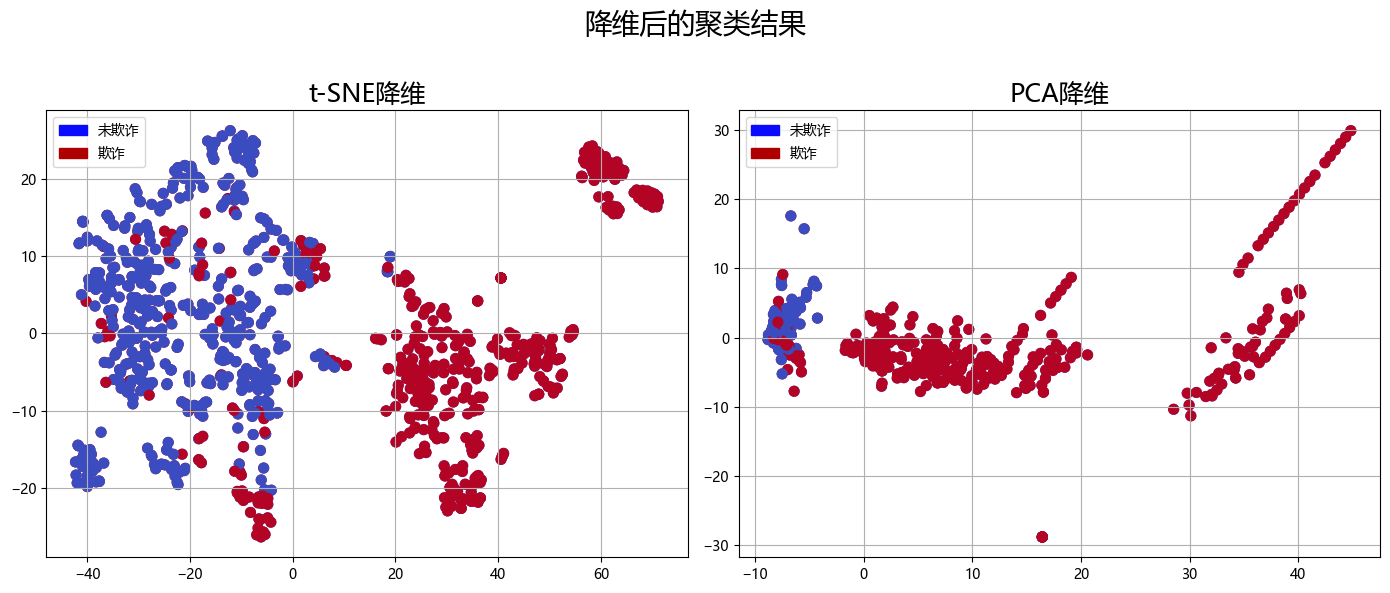

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Set the title
fig.suptitle('降维后的聚类结果', fontsize=20)

# Set the color
blue_patch = mpatches.Patch(color='#0A0AFF', label='未欺诈')
red_patch = mpatches.Patch(color='#AF0000', label='欺诈')

# t-SNE
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='未欺诈', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='欺诈', linewidths=2)
ax1.set_title('t-SNE降维', fontsize=18)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='未欺诈', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='欺诈', linewidths=2)
ax2.set_title('PCA降维', fontsize=18)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [15]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [17]:
from sklearn.model_selection import cross_val_score
models = [('LogisiticRegression', LogisticRegression()), ('KNearest', KNeighborsClassifier()), ('Support Vector Classifier', SVC()), ('DecisionTreeClassifier', DecisionTreeClassifier())]
for key, classifier in models:
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print( key, "训练准确率为 "+ round(training_score.mean()* 100, 2).astype(str) +"%")

LogisiticRegression 训练准确率为 94.32%
KNearest 训练准确率为 92.6%
Support Vector Classifier 训练准确率为 92.99%
DecisionTreeClassifier 训练准确率为 88.51%


In [18]:
from sklearn.model_selection import GridSearchCV

# 定义逻辑回归的参数空间
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# 使用GridSearchCV进行逻辑回归的参数搜索
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# 得到最佳参数的逻辑回归模型
log_reg = grid_log_reg.best_estimator_

# 定义KNN的参数空间
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
# 使用GridSearchCV进行KNN的参数搜索
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# 得到最佳参数的KNN模型
knears_neighbors = grid_knears.best_estimator_

# 定义SVM的参数空间
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
# 使用GridSearchCV进行SVM的参数搜索
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# 得到最佳参数的SVM模型
svc = grid_svc.best_estimator_

# 定义决策树的参数空间
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
# 使用GridSearchCV进行决策树的参数搜索
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# 得到最佳参数的决策树模型
tree_clf = grid_tree.best_estimator_


In [19]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('逻辑回归交叉验证准确率为 '+ round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('KNN交叉验证准确率为 '+ round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('SVM交叉验证准确率为 '+ round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('决策树交叉验证准确率为 '+round(tree_score.mean() * 100, 2).astype(str) + '%')

逻辑回归交叉验证准确率为 94.32%
KNN交叉验证准确率为 92.6%
SVM交叉验证准确率为 94.58%
决策树交叉验证准确率为 91.41%


In [20]:
# 我们将在交叉验证期间使用欠采样技术
undersample_X = df.drop('Class', axis=1) # 删除标签列之外的所有特征列，得到特征数据
undersample_y = df['Class'] # 获取标签列

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    # 在训练数据和测试数据中分别获取特征和标签
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values 
undersample_Xtest = undersample_Xtest.values 
undersample_ytrain = undersample_ytrain.values 
undersample_ytest = undersample_ytest.values 

undersample_accuracy = [] # 存储准确率
undersample_precision = [] # 存储精确率
undersample_recall = [] # 存储召回率
undersample_f1 = [] # 存储 F1 分数
undersample_auc = [] # 存储 AUC-ROC

# 实现 NearMiss 技术
# 输出 NearMiss 分布（仅用于查看数据分布，不会使用这些变量）
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# 正确的交叉验证方式
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    # 使用 imbalanced_make_pipeline 函数构建包含 NearMiss 算法和逻辑回归的流水线
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    # 在训练数据上拟合模型
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    # 在测试数据上进行预测
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    # 计算准确率、精确率、召回率、F1 分数和 AUC-ROC 等指标
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))


Train: [ 56951  56952  56953 ... 284804 284805 284806] Test: [    0     1     2 ... 63888 64144 64195]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56951  56952  56953 ... 119669 122054 122231]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113912 113913 113914 ... 170882 171733 172436]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170883 170884 170885 ... 227845 227846 227847]
Train: [     0      1      2 ... 227845 227846 227847] Test: [227250 227421 227848 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


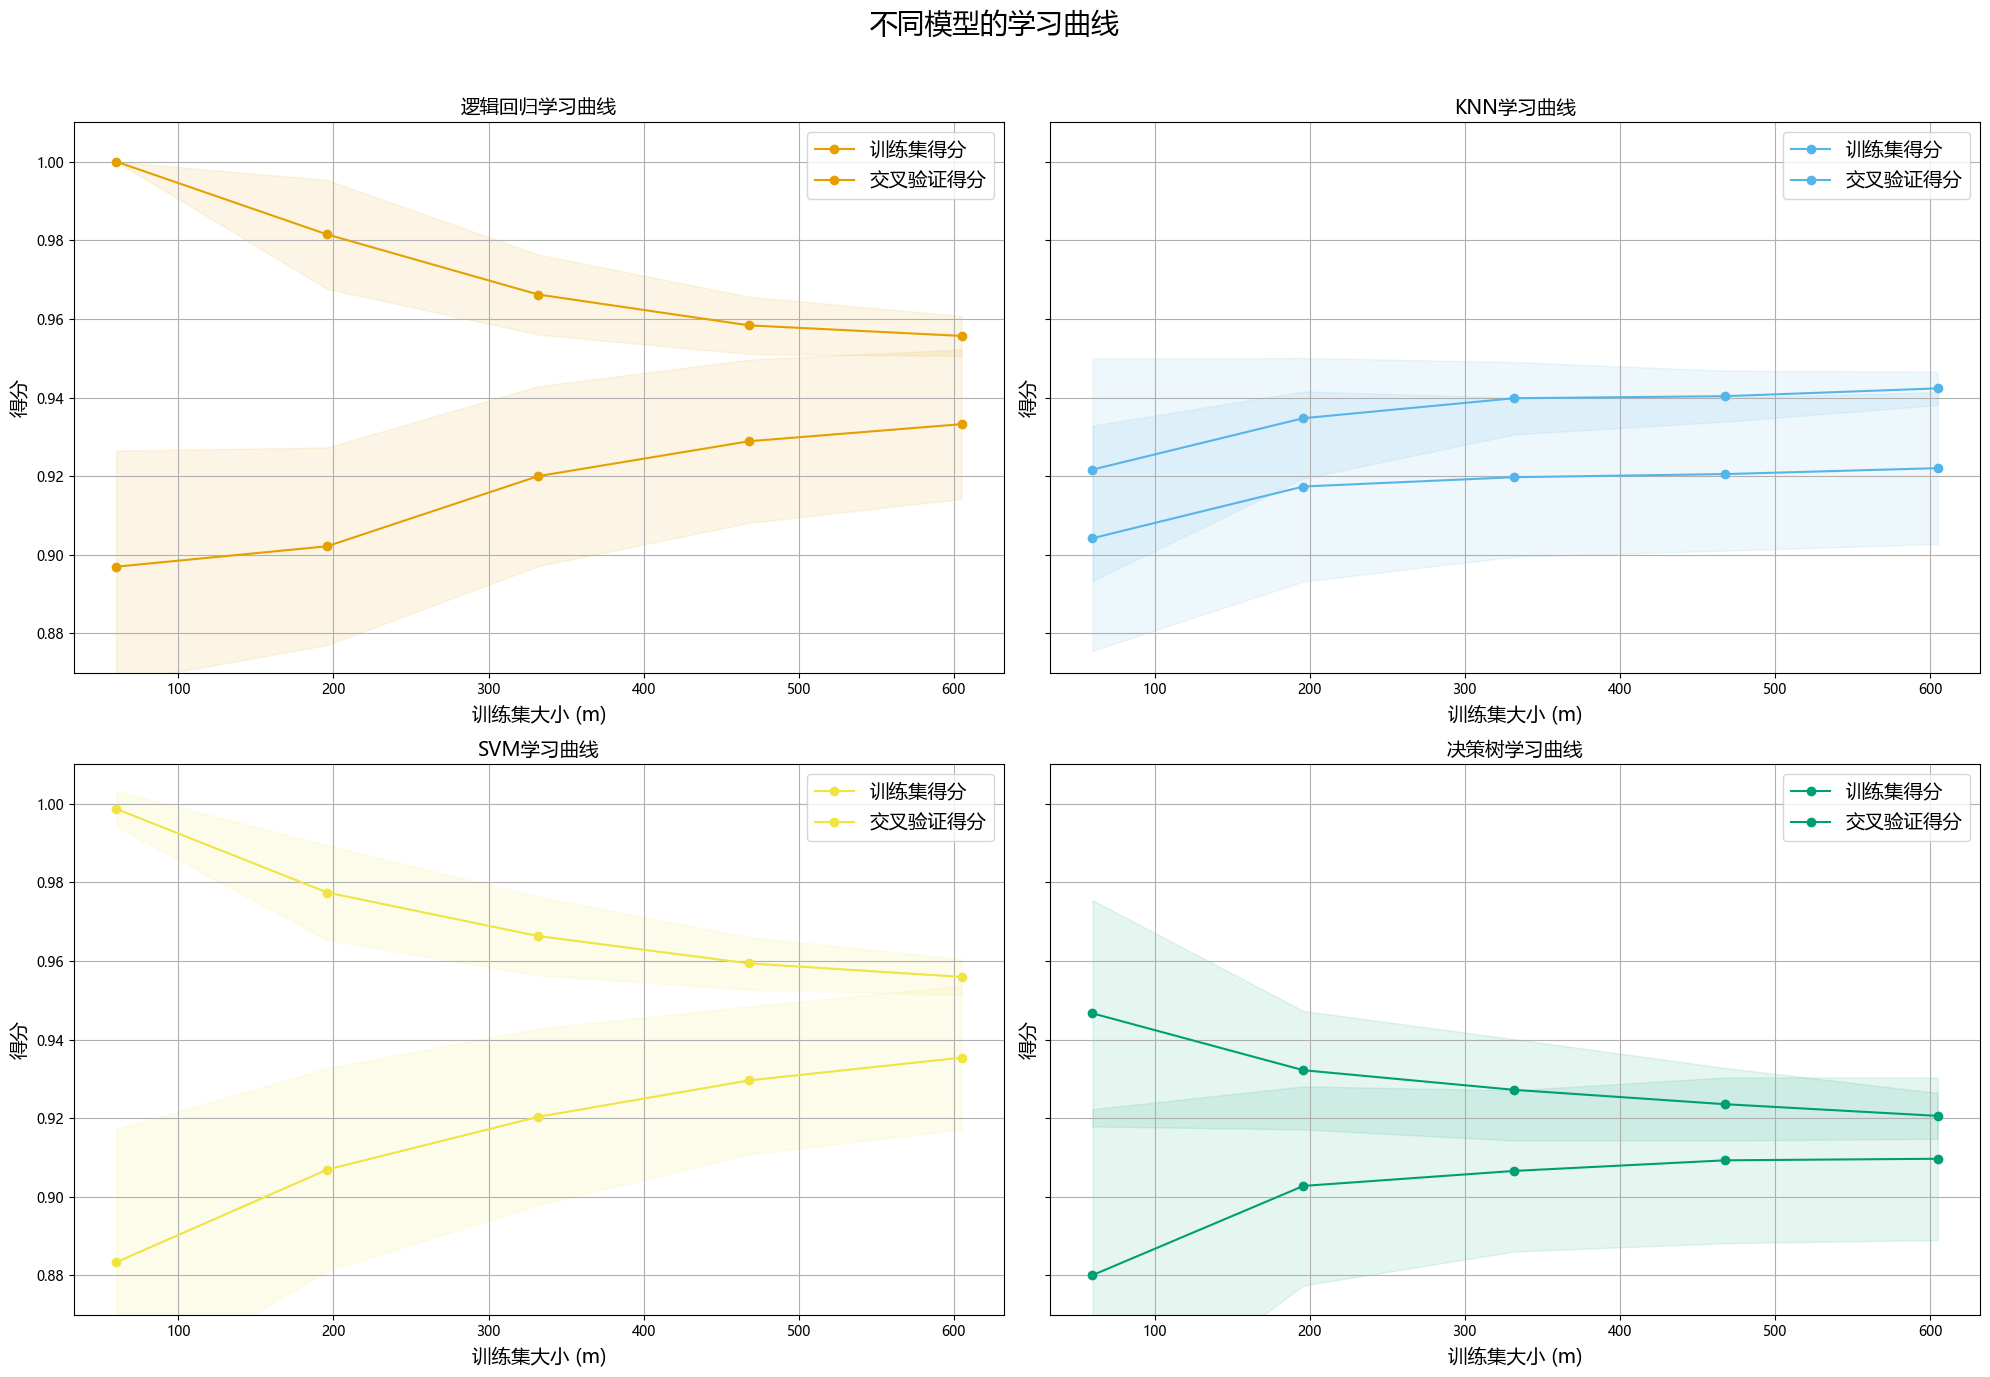

In [21]:
from sklearn.model_selection import ShuffleSplit, learning_curve
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    # 创建子图
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # Set the colors
    colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73']

    # 准备画图
    for i, estimator in enumerate([estimator1, estimator2, estimator3, estimator4]):
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                                n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        ax = [ax1, ax2, ax3, ax4][i]
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color=colors[i])
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color=colors[i])
        ax.plot(train_sizes, train_scores_mean, 'o-', color=colors[i], 
                 label="训练集得分")
        ax.plot(train_sizes, test_scores_mean, 'o-', color=colors[i],
                 label="交叉验证得分")
        ax.set_title(["逻辑回归学习曲线", "KNN学习曲线", "SVM学习曲线", "决策树学习曲线"][i], fontsize=14)
        ax.set_xlabel('训练集大小 (m)', fontsize=14)
        ax.set_ylabel('得分', fontsize=14)
        ax.grid(True)
        ax.legend(loc="best", fontsize=14)
        
    # 设置全局标题
    f.suptitle('不同模型的学习曲线', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)


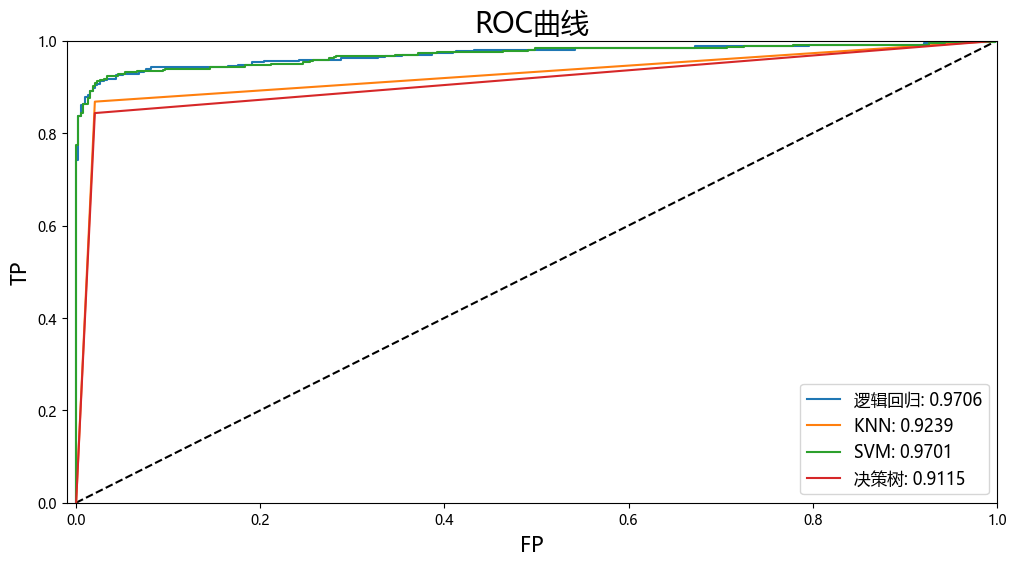

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

# 用cross_val_predict计算各个分类器的预测值
predictions_logreg = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
predictions_knn = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
predictions_svc = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
predictions_tree = cross_val_predict(tree_clf, X_train, y_train, cv=5)

# 计算FPR和TPR
fpr_logreg, tpr_logreg, _ = roc_curve(y_train, predictions_logreg)
fpr_knn, tpr_knn, _ = roc_curve(y_train, predictions_knn)
fpr_svc, tpr_svc, _ = roc_curve(y_train, predictions_svc)
fpr_tree, tpr_tree, _ = roc_curve(y_train, predictions_tree)

def draw_roc_curves(*args):
    """
    Function to draw ROC curves for classifiers.
    Arguments are tuples consisting of FPR, TPR, label, and prediction.
    """
    plt.figure(figsize=(12,6))
    plt.title('ROC曲线', fontsize=20)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('FP', fontsize=15)
    plt.ylabel('TP', fontsize=15)

    for fpr, tpr, label, prediction in args:
        auc_score = roc_auc_score(y_train, prediction)
        plt.plot(fpr, tpr, label=f'{label}: {auc_score:.4f}')

    plt.legend(fontsize=12)
    plt.show()

# 绘制ROC曲线
draw_roc_curves(
    (fpr_logreg, tpr_logreg, '逻辑回归', predictions_logreg),
    (fpr_knn, tpr_knn, 'KNN', predictions_knn),
    (fpr_svc, tpr_svc, 'SVM', predictions_svc),
    (fpr_tree, tpr_tree, '决策树', predictions_tree)
)


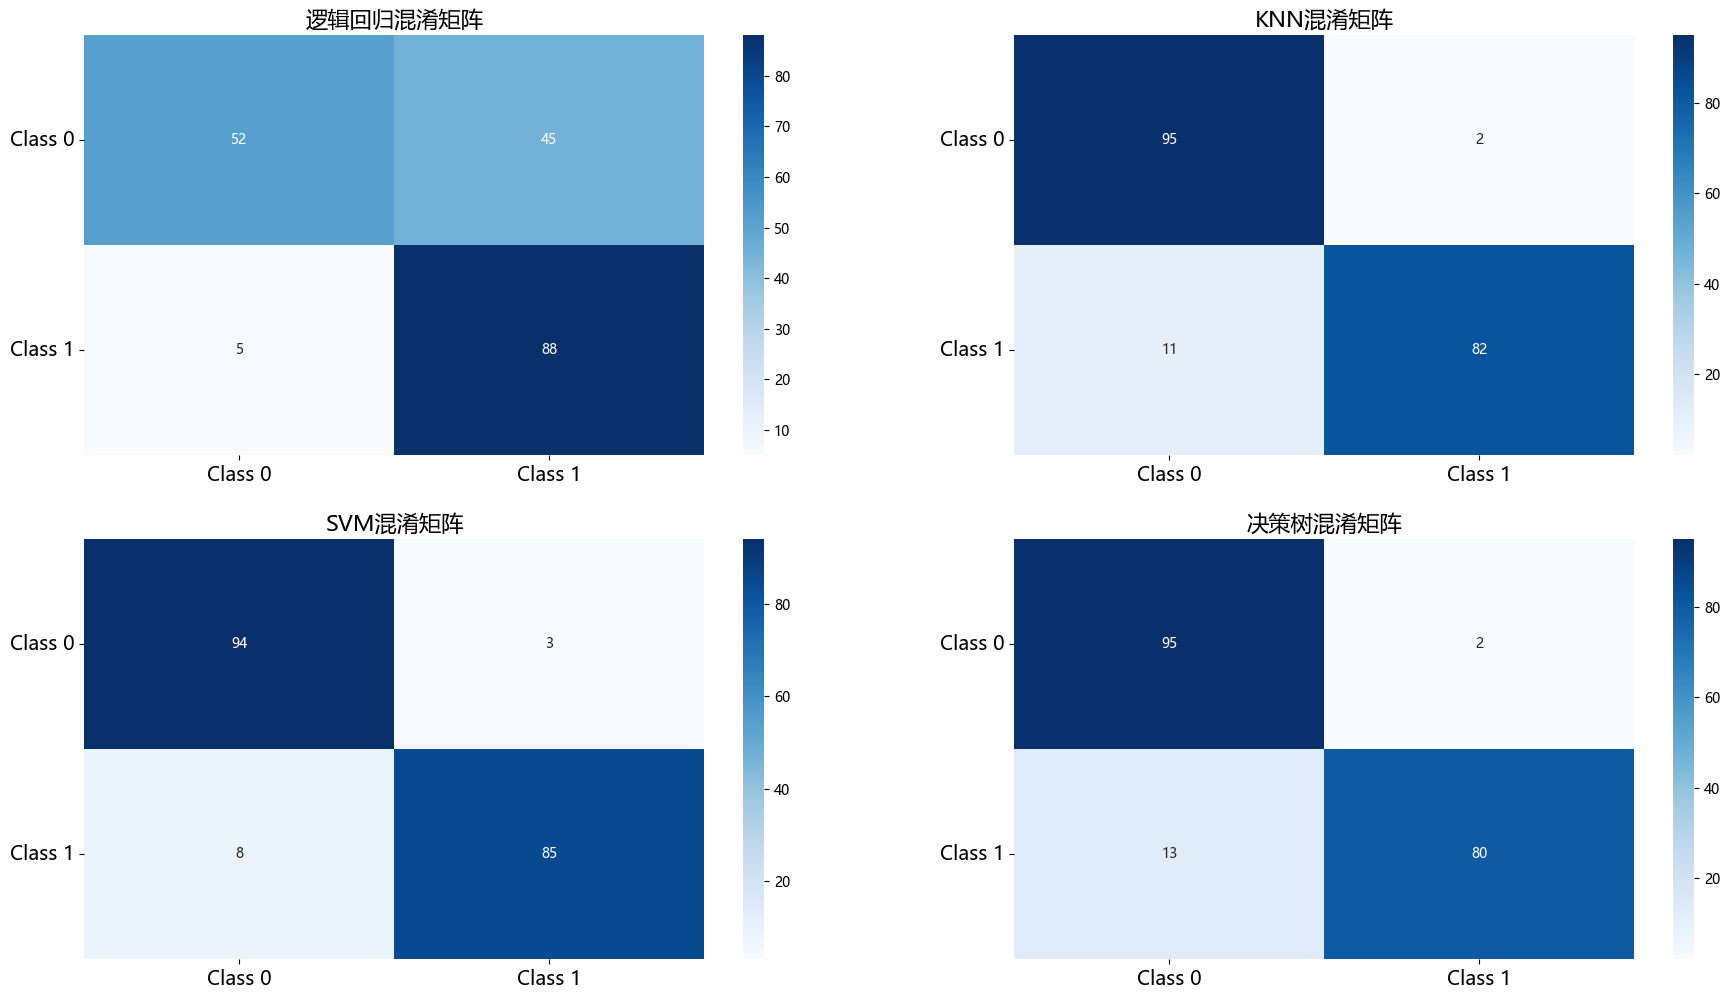

In [23]:
from sklearn.metrics import confusion_matrix

# 对四个模型在测试集上进行预测
log_reg_predictions = log_reg.predict(X_test)
kneighbors_predictions = knears_neighbors.predict(X_test)
svc_predictions = svc.predict(X_test)
tree_predictions = tree_clf.predict(X_test)

# 创建混淆矩阵
log_reg_cm = confusion_matrix(y_test, log_reg_predictions)
kneighbors_cm = confusion_matrix(y_test, kneighbors_predictions)
svc_cm = confusion_matrix(y_test, svc_predictions)
tree_cm = confusion_matrix(y_test, tree_predictions)

# 利用Seaborn的heatmap绘制混淆矩阵
fig, axes = plt.subplots(2, 2, figsize=(22,12))

sns.heatmap(log_reg_cm, ax=axes[0, 0], annot=True, cmap='Blues')
axes[0, 0].set_title("逻辑回归混淆矩阵", fontsize=16)
axes[0, 0].set_xticklabels(['Class 0', 'Class 1'], fontsize=14)
axes[0, 0].set_yticklabels(['Class 0', 'Class 1'], fontsize=14, rotation=0)

sns.heatmap(kneighbors_cm, ax=axes[0, 1], annot=True, cmap='Blues')
axes[0, 1].set_title("KNN混淆矩阵", fontsize=16)
axes[0, 1].set_xticklabels(['Class 0', 'Class 1'], fontsize=14)
axes[0, 1].set_yticklabels(['Class 0', 'Class 1'], fontsize=14, rotation=0)

sns.heatmap(svc_cm, ax=axes[1, 0], annot=True, cmap='Blues')
axes[1, 0].set_title("SVM混淆矩阵", fontsize=16)
axes[1, 0].set_xticklabels(['Class 0', 'Class 1'], fontsize=14)
axes[1, 0].set_yticklabels(['Class 0', 'Class 1'], fontsize=14, rotation=0)

sns.heatmap(tree_cm, ax=axes[1, 1], annot=True, cmap='Blues')
axes[1, 1].set_title("决策树混淆矩阵", fontsize=16)
axes[1, 1].set_xticklabels(['Class 0', 'Class 1'], fontsize=14)
axes[1, 1].set_yticklabels(['Class 0', 'Class 1'], fontsize=14, rotation=0)

plt.show()
